# import the dependencies

In [1]:
import sys
from collections import Counter

import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from transformers import RobertaTokenizerFast


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Prepare data

In [3]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [4]:
tokenizer = RobertaTokenizerFast.from_pretrained("./fine_models", max_len=512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
x_train = [x_.replace("@x.", "y") for x_ in x_train]
x_test = [x_.replace("@x.", "y") for x_ in x_test]

train_df = pd.DataFrame({"term_str": x_train, "steps_lo": y_train_})
test_df = pd.DataFrame({"term_str": x_test, "steps_lo": y_test_})

label_encoder = {key_: [0.0] * 31 for key_ in range(31)}
for key_ in label_encoder.keys():
    label_encoder[key_][key_] = 1.0

def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors="tf")
    labels = tf.convert_to_tensor([label_encoder[key_] for key_ in example["steps_lo"]])
    return tokenized_texts, labels


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [6]:
batch_size = 3

train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Configure the model

In [7]:
from transformers import BertConfig

config = BertConfig(
    vocab_size=10,
    hidden_size=69,
    num_hidden_layers=1,
    num_attention_heads=3,
    intermediate_size=32,
    max_position_embeddings=512,
    num_labels=31
)

# vocab_size=30522,
# hidden_size=768,
# num_hidden_layers=12,
# num_attention_heads=12,
# intermediate_size=3072,
# hidden_act="gelu",
# hidden_dropout_prob=0.1,
# attention_probs_dropout_prob=0.1,
# max_position_embeddings=512,
# type_vocab_size=2,
# initializer_range=0.02,
# layer_norm_eps=1e-12,
# pad_token_id=0,
# position_embedding_type="absolute",
# use_cache=True,
# classifier_dropout=None,

In [8]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification(config=config)

In [9]:
model.build()
model.get_layer("bert").trainable = True
model.get_layer("classifier").trainable = True
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])

In [10]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  65237     
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2170      
                                                                 
Total params: 67,407
Trainable params: 67,407
Non-trainable params: 0
_________________________________________________________________


# Train a language model

In [11]:
epochs = 100
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/100
984/984 [==============================] - 27s 21ms/step - loss: 8.1767 - accuracy: 0.0972 - val_loss: 8.5498 - val_accuracy: 0.0893
Epoch 2/100
984/984 [==============================] - 20s 20ms/step - loss: 8.2920 - accuracy: 0.0867 - val_loss: 7.6042 - val_accuracy: 0.0893
Epoch 3/100
984/984 [==============================] - 20s 20ms/step - loss: 8.0354 - accuracy: 0.0827 - val_loss: 8.5498 - val_accuracy: 0.0893
Epoch 4/100
984/984 [==============================] - 20s 20ms/step - loss: 8.0217 - accuracy: 0.0867 - val_loss: 7.5683 - val_accuracy: 0.0893
Epoch 5/100
984/984 [==============================] - 20s 21ms/step - loss: 7.9188 - accuracy: 0.0881 - val_loss: 8.5498 - val_accuracy: 0.0893
Epoch 6/100
984/984 [==============================] - 20s 20ms/step - loss: 8.2720 - accuracy: 0.0857 - val_loss: 8.5498 - val_accuracy: 0.0893
Epoch 7/100
984/984 [==============================] - 20s 20ms/step - loss: 8.1136 - accuracy: 0.0840 - val_loss: 8.5498 - val_ac

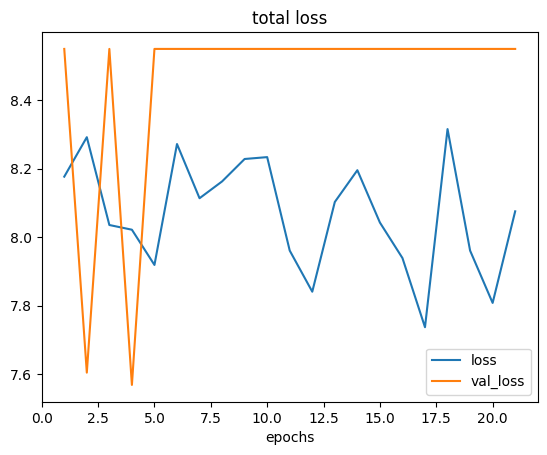

In [12]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

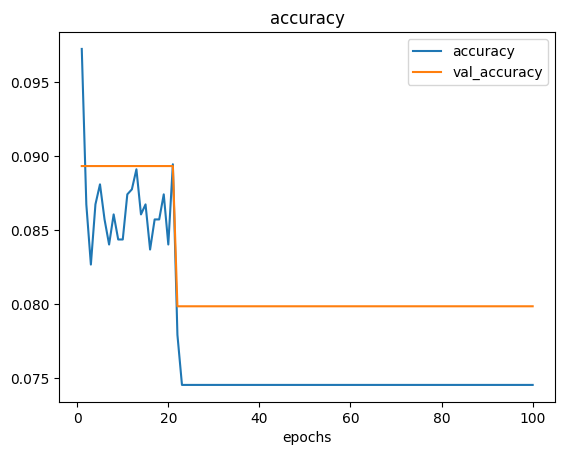

In [13]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [14]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

247/247 [==============================] - 2s 6ms/step


In [15]:
train_preds_nums = [np.argmax(x_) for x_ in train_preds.logits]
test_preds_nums = [np.argmax(x_) for x_ in test_preds.logits]
train_true_nums = y_train_
test_true_nums = y_test_

In [19]:
train_preds.logits

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [16]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

Train accuracy: 0.07452574525745258


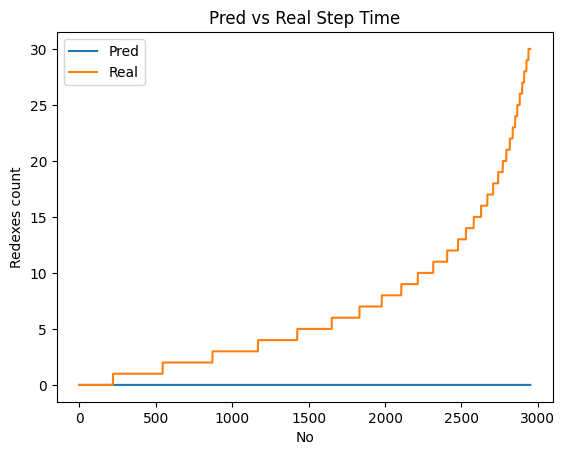

In [17]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)

Test accuracy: 0.07983761840324763


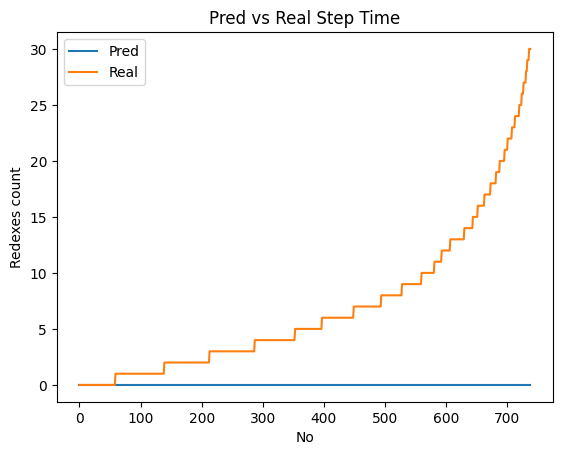

In [18]:
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)